<a href="https://colab.research.google.com/github/mertdemir0/fcc-sms-text-classification/blob/main/fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [9]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk import word_tokenize
nltk.download('punkt')
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from xgboost import XGBRegressor

print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
2.9.0-dev20220301


In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2022-03-01 11:03:14--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.09s   

2022-03-01 11:03:15 (3.63 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2022-03-01 11:03:15--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==========

In [3]:
# Read data into pandas' dataframes

df_train = pd.read_csv(train_file_path, sep='\t', header=None, names=['label', 'message'])
df_test = pd.read_csv(test_file_path, sep='\t', header=None, names=['label', 'message'])
df_test.head()

,label,message
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [4]:
# Convert labels to categorical data and replace text with code values

df_train['label'] = df_train['label'].astype('category').cat.codes
df_test['label'] = df_test['label'].astype('category').cat.codes

In [5]:
# Split data into labels and features

train_features = df_train.copy()
test_features = df_test.copy()
train_labels = train_features.pop('label')
test_labels = test_features.pop('label')

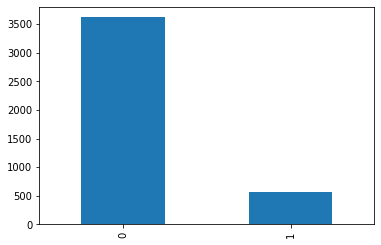

In [6]:
# Analyse dataset
# Draw histogram showing number of 'ham' and 'spam' messages
df_train['label'].value_counts().plot.bar();

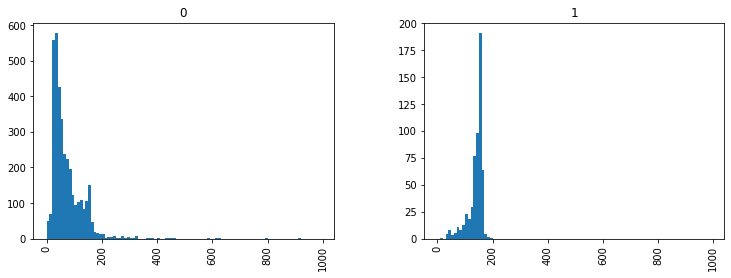

In [7]:
# Draw histogram showing length of 'ham' and 'spam' messages
df_len = pd.DataFrame(df_train)
df_len['length'] = df_len['message'].apply(len)
df_len.hist(column='length', by='label', bins=range(0, 1000, 10), figsize=(12,4));

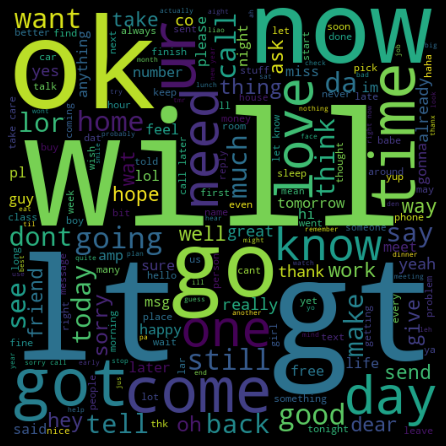

In [10]:
# Draw WordCloud for 'ham' words
ham_words = ' '.join(list(df_train[df_train['label'] == 0]['message']))
ham_wc = WordCloud(width=512, height=512).generate(ham_words)
plt.figure(figsize=(10,6), facecolor='k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [11]:
# Preprocess data

# Define function for message processing
def process_message(msg):
  # Make everything lowercase and skip punctuation characters
  msg = ''.join(char for char in msg.lower() if char not in set(string.punctuation))
  # Tokenize message but skip stopwords like 'the', 'a', etc.
  word_list = [word for word in word_tokenize(msg) if word not in stopwords.words('english')]
  return word_list

In [12]:
# Create bag-of-words transformer
# Concatenate train and test data
data_features = pd.concat([train_features, test_features])
data_labels = pd.concat([train_labels, test_labels])
# Create bag-of-words transformer that keeps vocabulary with all words
bow_transformer = CountVectorizer(analyzer=process_message).fit(data_features['message'])
# Print number of words in vocabulary
print(len(bow_transformer.vocabulary_))

9496


In [13]:
# Vectorize a message using a bag-of-words transformer
sample_msg = train_features['message'][0]
bow_sample_msg = bow_transformer.transform([sample_msg])
print(sample_msg)
print(bow_sample_msg)

ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it.
  (0, 1066)	1
  (0, 1213)	1
  (0, 1444)	1
  (0, 2292)	1
  (0, 2775)	1
  (0, 2898)	1
  (0, 2940)	1
  (0, 3916)	1
  (0, 4356)	1
  (0, 4799)	1
  (0, 4989)	1
  (0, 5782)	1
  (0, 7010)	1
  (0, 8299)	1
  (0, 8600)	2
  (0, 8693)	1
  (0, 9141)	1


In [14]:
# Apply bag-of-words transformer to all messages

bow_data = bow_transformer.transform(data_features['message'])
print(bow_data.shape)

(5571, 9496)


In [15]:
# Percentage of non-zero entries to the matrix size

print(bow_data.nnz / (bow_data.shape[0] * bow_data.shape[1]) * 100)

0.09482211482407467


In [16]:
# Use TF-IDF (Term Frequency times Inverse Document Frequency) transformer to account for the total number of words in each document and to downscale weights for words that occur in many documents

tfidf_transformer = TfidfTransformer().fit(bow_data)

In [18]:
# Show a sample message with weights calculated using TF-IDF transformer

tfidf_sample = tfidf_transformer.transform(bow_sample_msg)
print(tfidf_sample)

  (0, 9141)	0.3193536147571175
  (0, 8693)	0.33453929686752293
  (0, 8600)	0.21963536951370996
  (0, 8299)	0.33453929686752293
  (0, 7010)	0.19323996644726754
  (0, 5782)	0.18549026826246273
  (0, 4989)	0.157156822738756
  (0, 4799)	0.15477050617704852
  (0, 4356)	0.13383352007920915
  (0, 3916)	0.22328984800432256
  (0, 2940)	0.2742618228607118
  (0, 2898)	0.15267261779364014
  (0, 2775)	0.19685264460210067
  (0, 2292)	0.3085792018329111
  (0, 1444)	0.23069891672907558
  (0, 1213)	0.20032755250826478
  (0, 1066)	0.33453929686752293


In [19]:
# Transform all data using TF-IDF transformer

data_tfidf = tfidf_transformer.transform(bow_data)
np.shape(data_tfidf)

(5571, 9496)

In [20]:
# Split data into training and testing part

X_train, X_test, y_train, y_test = train_test_split(data_tfidf, data_labels, test_size=0.25, random_state=0)

In [21]:
# First attempt: use random forest classifier

rf_clf = RandomForestClassifier(n_estimators=250, random_state=0)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

In [23]:
# Second attempt: use XGBoost regressor

xgb_clf = XGBRegressor(n_estimators=120, learning_rate=0.125)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

[11:17:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [24]:
# Third attempt: use GridSearchCV classifier. This method is the best according to the classification results compared to the other methods that were tested.
param_grid = {'C': [0.1, 1, 10, 100],
  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
  'gamma':['scale', 'auto'],
  'kernel': ['linear']}
   
gsc_clf = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=0, n_jobs=-1)
gsc_clf.fit(X_train, y_train)
y_pred = gsc_clf.predict(X_test)

In [25]:
# Show classification results. Assume that probability of 0.5 is a threshold between 'spam' and 'ham' message.

print(confusion_matrix(y_test,(y_pred>0.5)))
print(classification_report(y_test,(y_pred>0.5)))
print(accuracy_score(y_test,(y_pred>0.5)))

[[1211    0]
 [  26  156]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1211
           1       1.00      0.86      0.92       182

    accuracy                           0.98      1393
   macro avg       0.99      0.93      0.96      1393
weighted avg       0.98      0.98      0.98      1393

0.9813352476669059


In [26]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  bow_pred_text = bow_transformer.transform([pred_text])
  tfidf_pred_text = tfidf_transformer.transform(bow_pred_text)
  pred = gsc_clf.predict_proba(tfidf_pred_text)[0]
  prediction = [pred[1], 'ham' if pred[0] > 0.5 else 'spam']
  return (prediction)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[0.011547273098205363, 'ham']


In [27]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!
